### Twitter’s Political Divide	
Twitter allows groups of all kinds to find a community online. This is especially true with in the realm of politics. It’s commonly acknowledged that social media had some part in the division in politics. People of both sides of the political spectrum are more reinforced by their own ideology. Example of two polar opposites are demonstrated by the hashtags #resist #maga. Resist, comes from the resistance, referring to resisting the policies and ideology of the Trump administration. MAGA, or Make America Great Again, is the Trump base, his most devout supporter. The aim here is to find a classifier that looks at the two groups and find that’s most informative words that separate the two tweets (minus the #maga and #resist of course). 

The goal of this project is two folds.
-	Collected a dataset that looked at the #MAGA and #Resist hashtags on Twitter using Tweepy.
-	Created a classifier to predict category and looked at most predictive words for each tag.

In [1]:
from tweepy import Stream
from tweepy import OAuthHandler
from tweepy.streaming import StreamListener
import time
import json

# consumer key, consumer secret, access token, access secret.
ckey = "GET IT FROM TWITTER"
csecret = "GET IT FROM TWITTER"
atoken = "GET IT FROM TWITTER"
asecret = "GET IT FROM TWITTER"


class listener(StreamListener):
    def on_data(self, data):
        try:
            all_data = json.loads(data)
            tweet = all_data["text"]
            output = open("MAGA.txt", "a") # switch with 
            output.write(tweet.replace('\n', ' ').replace('\r', ' '))
            output.write('\n')
            output.close()
            # time.sleep(.3)  # include to print tweets and vizually check
            # print(tweet)
            return True
        except:
            pass

    def on_error(self, status):
        print(status)

auth = OAuthHandler(ckey, csecret)
auth.set_access_token(atoken, asecret)

twitterStream = Stream(auth, listener())
# twitterStream.filter(track=["MAGA"])
# twitterStream.filter(track=["resist"])

The data was collected from twitter on a different IDE (Spyder) on Tuesday August 15, 2017 from 3 - 6 pm Eastern time. Script for each tag was aborted after running for close to an hour giving close to 4K tweets for each tag. Ideally, we would have a more stratified sample since the tweets related to the news of the day, however due to resource constraints we will use this.

In [2]:
import nltk
import random
from nltk.tokenize import word_tokenize
import pickle


resist_tweets = open("resist.txt", "r").read()
maga_tweets = open("MAGA.txt", "r").read()

all_tweets = []

for r in resist_tweets.split('\n'):   
    r = r.lower()
    j = r
    r = r.replace("resist", "")
    all_tweets.append((r, "r"))

for m in maga_tweets.split('\n'):
    m = m.lower()
    k = m
    m = m.replace("maga", "")
    all_tweets.append((m, "m"))

all_words = []

resist_tokenize = word_tokenize(resist_tweets)
maga_tokenize = word_tokenize(maga_tweets)

for w in resist_tokenize:
    all_words.append(w.lower())

for w in maga_tokenize:
    all_words.append(w.lower())

all_words = nltk.FreqDist(all_words)

word_features = list(all_words.keys())[:5000]


def find_features(document):
    words = word_tokenize(document)
    features = {}
    for w in word_features:
        features[w] = (w in words)

    return features


featuresets = [(find_features(rev), category) for (rev, category) in all_tweets]

random.shuffle(featuresets)

training_set = featuresets[:int(.7*len(featuresets))]
testing_set = featuresets[int(.7*len(featuresets)):]

classifier = nltk.NaiveBayesClassifier.train(training_set)
print("Original Naive Bayes Algo accuracy percent:",
      (nltk.classify.accuracy(classifier, testing_set))*100)
classifier.show_most_informative_features(50)

# All the  data will be pickled
save_featuresets = open("featuresets.pickle", "wb")
pickle.dump(featuresets, save_featuresets)
save_featuresets.close()

save_classifier = open("classifier.pickle", "wb")
pickle.dump(classifier, save_classifier)
save_classifier.close()

Original Naive Bayes Algo accuracy percent: 80.2124833997344
Most Informative Features
                  funder = True                r : m      =   1051.8 : 1.0
          dashannestokes = True                r : m      =    192.1 : 1.0
          quitthecouncil = True                r : m      =    166.3 : 1.0
                    town = True                r : m      =    112.6 : 1.0
                    hall = True                r : m      =    112.2 : 1.0
           truthfeednews = True                m : r      =    101.6 : 1.0
         the_trump_train = True                m : r      =     81.3 : 1.0
                    hats = True                m : r      =     76.3 : 1.0
                question = True                r : m      =     72.9 : 1.0
                  delete = True                m : r      =     72.6 : 1.0
                  leaves = True                r : m      =     68.6 : 1.0
                    meet = True                r : m      =     66.3 : 1.0
             

With a random shuffle, the data was trained on 70% of the tweets and tested on 30%, the training or test and received an 78% accuracy on the test set. The most informative features are listed above. M:R ration and R:M ratio shows how much more one is likely to predict over the other. (M being Maga and R being resist)

Below shows some wordcloud vizualiation to vizualize the differences in the tweets between the two groups.

In [23]:
import numpy as np
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

# df = pd.DataFrame(np.array(most_info).reshape(len(most_info),3), columns = ['word', 'prob', 'label'])
# most_info = classifier.show_most_informative_features(50)

def show_most_informative_features_in_list(classifier, n=10):
    """
    Return a nested list of the "most informative" features 
    used by the classifier along with it's predominant labels
    """
    cpdist = classifier._feature_probdist       # probability distribution for feature values given labels
    feature_list = []
    for (fname, fval) in classifier.most_informative_features(n):
        def labelprob(l):
            return cpdist[l, fname].prob(fval)
        
        labels = sorted([l for l in classifier._labels if fval in cpdist[l, fname].samples()], 
                        key=labelprob)
        feature_list.append([fname, cpdist[labels[-1], fname].prob(fval) , labels[-1]])
    return feature_list


most_info = show_most_informative_features_in_list(classifier, n=100)


(-0.5, 399.5, 199.5, -0.5)

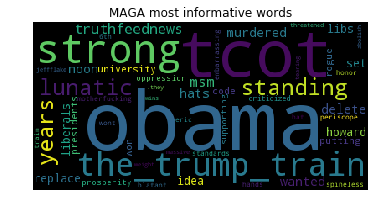

In [29]:
maga_info_words = {}
resist_info_word = {}

for i in most_info:
    if i[2] == 'm':
        maga_info_words[i[0]] = i[1]
    else:
        resist_info_word[i[0]] = i[1]

wordcloud = WordCloud().generate_from_frequencies(maga_info_words)
plt.imshow(wordcloud)
plt.title('MAGA most informative words')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

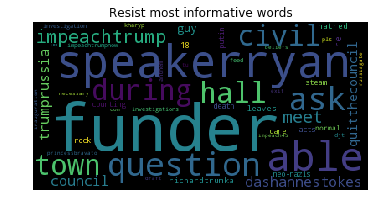

In [28]:
wordcloud = WordCloud().generate_from_frequencies(resist_info_word)
plt.imshow(wordcloud)
plt.title('Resist most informative words')
plt.axis("off")

The above two shows word clouds for 

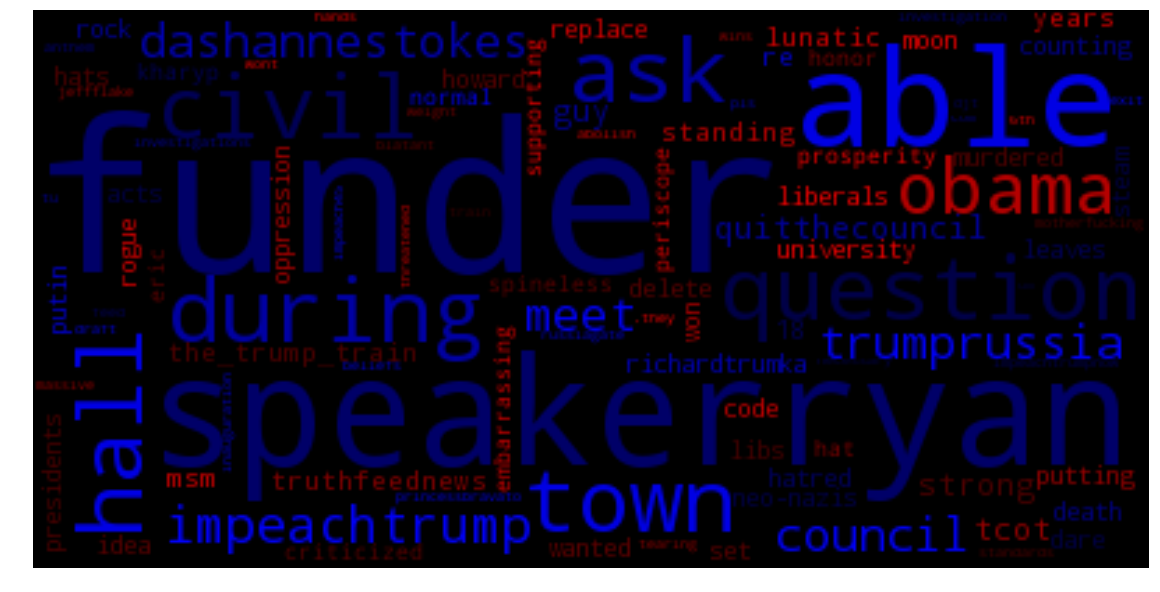

In [26]:
from wordcloud import get_single_color_func
class SimpleGroupedColorFunc(object):
    """Create a color function object which assigns EXACT colors
       to certain words based on the color to words mapping
       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """
    def __init__(self, color_to_words, default_color):
        self.word_to_color = {word: color
                              for (color, words) in color_to_words.items()
                              for word in words}

        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)


class GroupedColorFunc(object):
    """Create a color function object which assigns DIFFERENT SHADES of
       specified colors to certain words based on the color to words mapping.

       Uses wordcloud.get_single_color_func

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.color_func_to_words = [
            (get_single_color_func(color), set(words))
            for (color, words) in color_to_words.items()]

        self.default_color_func = get_single_color_func(default_color)

    def get_color_func(self, word):
        """Returns a single_color_func associated with the word"""
        try:
            color_func = next(
                color_func for (color_func, words) in self.color_func_to_words
                if word in words)
        except StopIteration:
            color_func = self.default_color_func

        return color_func

    def __call__(self, word, **kwargs):
        return self.get_color_func(word)(word, **kwargs)

info_words = {}
for i in most_info:
    info_words[i[0]] = i[1]

wc = WordCloud(collocations=False).generate_from_frequencies(info_words)

resist_w = [i[0] for i in most_info if i[2] == 'r']
maga_w = [i[0] for i in most_info if i[2] == 'm']

# map blue to resist, and red to maga
color_to_words = {'blue': resist_w, 'red': maga_w}

# Words that are not in any of the color_to_words values
# will be colored with a grey single color function
default_color = 'grey'

# Create a color function with single tone
# grouped_color_func = SimpleGroupedColorFunc(color_to_words, default_color)

# Create a color function with multiple tones
grouped_color_func = GroupedColorFunc(color_to_words, default_color)

# Apply our color function
wc.recolor(color_func=grouped_color_func)

# Plot
plt.figure(figsize=(20,16))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

This one shows all of the most informative words with Blue belonging to Resist and Red to Maga.